In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
# initialize params
seed = 294

num_iters = 1
T = 500  # time horizon
n = 50   # num historical samples
delta = 0.1
alpha = 0 # percentage of time to pull arm 0
mean_arms = [.5, .5-delta]  # note: arm 0 always better
n_arms = len(mean_arms)

In [7]:
np.random.seed(seed)
regret_data = []

def generate_dataset(n, alpha):
    """ generate historical samples """
    dataset = {'0': [], '1': []}
    for _ in range(int(alpha*n)):
        dataset['0'].append(np.random.binomial(p=mean_arms[0], n=1))
    for _ in range(n - int(alpha*n)):
        dataset['1'].append(np.random.binomial(p=mean_arms[1], n=1))
    return dataset

def conf_r(t, n_pulls):
    """ compute confidence radius """
#     return np.sqrt(2*np.log(1+t) / n_pulls)
    return np.sqrt(2*np.log(1+T) / n_pulls)
    

online_use_all_data_count = 0.0
online_data_use_percentage = []

algo_list = ['simple', 'online']

# simple algorithm (Thorsten 2012)
# basic UCB: no historical data
# online algorithm: Christina's

for i in range(num_iters):
    
    dataset = generate_dataset(n, alpha)
    online_samples = generate_dataset(2*T, .5) # gets samples which are used for the "online" samples
    
    # initialize counters
    online_data_index   = np.asarray([0,0]) # index of wrapper algorithm in historical samples
    online_regret_index = 0 # index of wrapper algorithm for using online samples
    
    regret = {}
    mean   = {}
    select = {}
    algo_index = {'simple': [0,0], 'no_history': [0,0], 'online': [0,0]} # index of algorithms in online samples
    
    for algo in algo_list:
        
        regret[algo] = 0
        mean[algo]   = np.asarray([0.0, 0.0])
        select[algo] = np.asarray([0, 0])
    
        mean['simple']   = np.asarray([max(0.0, np.mean(dataset['0'])), max(0.0, np.mean(dataset['1']))])
        select['simple'] = np.asarray([len(dataset['0']), len(dataset['1'])])
    
    for t in range(T+n):
        for algo in algo_list:   
            
            if np.sum(algo_index[algo]) < T: # not finished yet in the experiment
            
            # -----------------------------------
            # pick arm to pull
            # -----------------------------------
                ucb = np.asarray([mean[algo][arm] + conf_r(np.sum(algo_index[algo])+1, select[algo][arm]) \
                                      if select[algo][arm] > 0 else np.inf for arm in range(n_arms)])
                
                arm = np.argmax(ucb)
                select[algo][arm] += 1

                if algo == 'online':
                    # if we haven't used all offline samples of the chosen arm
                    if online_data_index[arm] < len(dataset[str(arm)]):
                        obs = dataset[str(arm)][online_data_index[arm]]
                        mean[algo][arm] = (mean[algo][arm] * select[algo][arm] + obs) / (select[algo][arm]+1)
                        online_data_index[arm] += 1
                        continue
                    # if we HAVE used all offline samples of the chosen arm
                    else:
                        online_regret_index += 1

                # -----------------------------------
                # get observation and record
                # -----------------------------------
                regret[algo] += mean_arms[0] - mean_arms[arm]
                regret_data.append({'Algo': algo, 'Iter': i, 't': np.sum(algo_index[algo]), 'Regret': regret[algo]})
                obs = online_samples[str(arm)][algo_index[algo][arm]]
                algo_index[algo][arm] += 1
                mean[algo][arm] = (mean[algo][arm]*select[algo][arm] + obs) / (select[algo][arm]+1)

            
    # meta trackers on behavior of online algorithm
    if online_data_index[0] == len(dataset['0']) and online_data_index[1] == len(dataset['1']):
        online_use_all_data_count += 1
    
    online_data_use_percentage.append((online_data_index[0] + online_data_index[1]) / n)

print('----------------------------')
print('Stats from online algorithm')
print(f'  # pulls of each arm in historical data:     {online_data_index}')
print(f'  Percentage of trials entire dataset used:   {100 * online_use_all_data_count / num_iters}')
print(f'  Average percentage of historical data used: {100*np.mean(online_data_use_percentage):.2f}')

----------------------------
Stats from online algorithm
  # pulls of each arm in historical data:     [ 0 50]
  Percentage of trials entire dataset used:   100.0
  Average percentage of historical data used: 100.00


/home/sean/anaconda3/envs/warm_start/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sean/anaconda3/envs/warm_start/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<bound method NDFrame.tail of        Algo  Iter    t  Regret
0    simple     0    0     0.0
1    online     0    0     0.0
2    simple     0    1     0.0
3    simple     0    2     0.0
4    simple     0    3     0.0
..      ...   ...  ...     ...
995  online     0  495    16.4
996  online     0  496    16.4
997  online     0  497    16.4
998  online     0  498    16.4
999  online     0  499    16.4

[1000 rows x 4 columns]>


Text(0.5, 1.0, 'n = 50, delta = 0.1, alpha = 0')

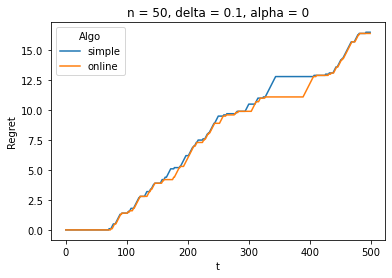

In [8]:
df = pd.DataFrame(regret_data)
print(df.tail)
p = sns.lineplot(data = df, x="t", y="Regret", hue="Algo", ci=None) #, ci="sd")
p.set_title(f"n = {n}, delta = {delta}, alpha = {alpha}") 
